# Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd

from fastai.vision import *
from fastai.vision.models.xresnet import *

# for datablock API
from fastai.vision.image import _resolve_tfms, _get_crop_target, _round_multiple, _get_resize_target, _affine_grid, _grid_sample, _affine_mult

# for XResNet
from fastai.vision.models.xresnet import act_fn, init_cnn, conv, noop, conv_layer, ResBlock, filt_sz


In [3]:
from fastai.callbacks import CSVLogger, ReduceLROnPlateauCallback, SaveModelCallback

In [4]:
from nb_new_data_augmentation_adacos import *

In [5]:
import pdb

In [6]:
__version__

'1.0.55'

# 6D image test

In [7]:
class Image6D(Image):
    "Support applying transforms to image data in `px`."
    def __init__(self, px:Tensor):
        self._px = px
        self._logit_px=None
        self._flow=None
        self._affine_mat=None
        self.sample_kwargs = {}

    def _repr_image_format(self, format_str):
        with BytesIO() as str_buffer:
            #plt.imsave(str_buffer, image2np(self.px[:3]), format=format_str)
            plt.imsave(str_buffer, 
                       np.concatenate((image2np(self.px[:3]), 
                                       image2np(self.px[3:])), axis=1),
                       format=format_str)
            return str_buffer.getvalue()

In [8]:
def open_image_6D(fn:PathOrStr, div:bool=True, convert_mode:str='L', cls:type=Image6D,
        after_open:Callable=None)->Image:
    "Return `Image` object created from image in file `fn`."
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        
        x = []
        for i in range(6):
            c = PIL.Image.open(fn+'_w'+str(i+1)+'.png').convert(convert_mode)
            if after_open: c = after_open(c)
            c = np.asarray(c)
            c = torch.from_numpy(c.astype(np.float32, copy=False))
            x.append(c)
            
    x = torch.stack(x)
    if div: x.div_(255)
    return cls(x)

In [9]:
#PATH_trunc = 'train/HEPG2-01/Plate1/B02_s1' # path is missing suffix "_w1.png"
#open_image_6D(PATH_trunc)

# Dataset setup

In [10]:
class ImageList6D(ImageList): #ImageList
    def __init__(self, *args, convert_mode='L', after_open:Callable=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.convert_mode,self.after_open = convert_mode,after_open
        self.copy_new.append('convert_mode')
        self.c,self.sizes = 6,{}
        
    def open(self, fn):
        "Open image in `fn`, subclass and overwrite for custom behavior."
        return open_image_6D(fn, convert_mode=self.convert_mode, after_open=self.after_open)

#    def show(self, img):
#        #return torch.cat((img[i][:3], img[i][3:]), dim=1)
#        show_image(img)
    
    # https://docs.fast.ai/tutorial.itemlist.html#Advanced-show-methods
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(15,10), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            #xs[i].show(ax=ax, y=ys[i], **kwargs)
            img = Image6D(torch.cat((xs[i].data[:3], xs[i].data[3:]), dim=2)) # works but not elegant?
            #img = Image6D(xs[i]) # does not work?
            img.show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()

In [11]:
#def show_image(img:Image, ax:plt.Axes=None, figsize:tuple=(3,3), hide_axis:bool=True, cmap:str='binary',
#                alpha:float=None, **kwargs)->plt.Axes:
#    "Display `Image` in notebook."
#    if ax is None: fig,ax = plt.subplots(figsize=figsize)
#    pdb.set_trace()
#    #ax.imshow(image2np(img.data), cmap=cmap, alpha=alpha, **kwargs)
#    ax.imshow(np.concatenate((image2np(self.px[:3]),
#                              image2np(self.px[3:])), axis=1),
#              cmap=cmap, alpha=alpha, **kwargs)
#    if hide_axis: ax.axis('off')
#    return ax


## Full dataset

### Dataset raw files

In [12]:
df_train = pd.read_csv('full_train_dataset_valid-split-ex_v2_20190727.csv', index_col=0)
df_test = pd.read_csv('full_test_dataset_v2_20190727.csv', index_col=0)

In [13]:
df_train.shape

(73030, 5)

In [14]:
df_train.tail()

,path,experiment,sirna,multi,valid
36510,U2OS-03/Plate4/O19_s2,U2OS-03,103,U2OS-03 103,1
36511,U2OS-03/Plate4/O20_s2,U2OS-03,202,U2OS-03 202,1
36512,U2OS-03/Plate4/O21_s2,U2OS-03,824,U2OS-03 824,1
36513,U2OS-03/Plate4/O22_s2,U2OS-03,328,U2OS-03 328,1
36514,U2OS-03/Plate4/O23_s2,U2OS-03,509,U2OS-03 509,1


In [15]:
df_test.tail()

,path,experiment
19892,U2OS-05/Plate4/O19_s2,U2OS-05
19893,U2OS-05/Plate4/O20_s2,U2OS-05
19894,U2OS-05/Plate4/O21_s2,U2OS-05
19895,U2OS-05/Plate4/O22_s2,U2OS-05
19896,U2OS-05/Plate4/O23_s2,U2OS-05


### Color augmentation transformation

"Color Augmentation: Color variability can be increased by applying random color transformations to original training samples. We perform color augmentation by transforming every color channels Ic ← ac · Ic + bc, where ac and bc are drawn from uniform distributions ac ∼ U [0.9, 1.1] and bc ∼ U [−10, +10]." from Domain-adversarial neural networks to address the appearance variability of histopathology images

In [16]:
# from https://github.com/fastai/fastai/blob/master/fastai/vision/transform.py#L137
#def _rgb_randomize(x, channel:int=None, thresh:float=0.3):
#    "Randomize one of the channels of the input image"
#    if channel is None: channel = np.random.randint(0, x.shape[0] - 1)
#    x[channel] = torch.rand(x.shape[1:]) * np.random.uniform(0, thresh)
#    return x
#
#rgb_randomize = TfmPixel(_rgb_randomize)

In [17]:
# Scaling factor comes from byte tensor?
#10/255 = 0.0392156862745098

In [18]:
def _color_augmentation(x):
    "Randomize all channels of the input image"
    channel_count = x.shape[0] - 1
    
    # by transforming every color channels Ic ← ac · Ic + bc, 
    # where ac and bc are drawn from uniform distributions 
    # ac ∼ U [0.9, 1.1] and 
    # bc ∼ U [−10, +10].
    
    # x [0,1]
    
    for c in range(channel_count):
        #pdb.set_trace()
        #print(x.min(), x.max())
        ac = np.random.uniform(0.9, 1.1) #np.random.uniform(0.9, 1.1)
        bc = np.random.uniform(-0.1,0.1) #np.random.uniform(-10, 10)
        x[c] = x[c] * ac + bc
        
        # clipping to min 0 and max 1
        x[c] = torch.clamp(x[c], 0., 1.)
    
    return x

color_augmentation = TfmPixel(_color_augmentation)

### Transforms setup

In [67]:
## AdaCos-SE-XResNet50c --> FP32 !!!
# TRAINING
#sz, bs = 128, 8*20 # 7430MiB /  7952MiB
sz, bs = 256, 8*5 # 7475MiB /  7952MiB & 7395MiB /  7952MiB
#sz, bs = 512, 8 #
# PREDICTION
#sz, bs = 256, 8*25 # 5391MiB /  7952MiB
#sz, bs = 256, 8*40 # 7741MiB /  7952MiB
#sz, bs = 512, 8*5 # 6051MiB /  7952MiB
# DATA AUGM W/O AdaCos
#sz, bs = 128, 8*42 # 7937MiB /  7952MiB
#sz, bs = 256, 8*13 # 
#sz, bs = 512, 8*3 # 


## EfficientNet-B3
#sz, bs = 300, 8 # 4167MiB /  7952MiB
#sz, bs = 300, 8*2 # 78??MiB /  7952MiB // FP16: 4397MiB /  7952MiB
#sz, bs = 300, 8*4 # FP16: 7805MiB /  7952MiB

In [68]:
sz, bs

(256, 40)

In [69]:
# cutout params
int(sz*0.1), int(sz*0.5)

(25, 128)

In [22]:
# normal tfms
#tfms = get_transforms()

In [114]:
# extended tfms
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_rotate=90.0, max_zoom=1.1, 
                      max_lighting=0.2, max_warp=0.2, 
                      p_affine=0.75, p_lighting=0.75, 
                      xtra_tfms=[color_augmentation()])

# crop_pad: https://forums.fast.ai/t/misc-issues/35386/10

In [115]:
# extended tfms
#tfms = get_transforms(do_flip=True, flip_vert=True, 
#                      max_rotate=90.0, max_zoom=1.1, 
#                      max_lighting=0.2, max_warp=0.2, 
#                      p_affine=0.75, p_lighting=0.75, 
#                      xtra_tfms=[color_augmentation(), 
#                                 cutout(n_holes=(1,4), length=(int(sz*0.1), int(sz*0.5)), p=.5)])

In [116]:
#tfms = [[crop(size=sz, row_pct=(0,1), col_pct=(0,1))], []]

In [117]:
#tfms

In [ ]:
# change "crop_pad" from get_transforms to "crop"
# uniform for FIXED cropping
tfms[0][0] = crop(size=sz, row_pct=uniform(0,1), col_pct=uniform(0,1))
tfms[1][0] = crop(size=sz, row_pct=uniform(0,1), col_pct=uniform(0,1))

In [119]:
# train crop
tfms[0][0].kwargs['row_pct'], tfms[0][0].kwargs['col_pct']

(0.36246912325628444, 0.40398465508593273)

In [120]:
# valid crop
tfms[1][0].kwargs['row_pct'], tfms[1][0].kwargs['col_pct']

(0.917419697949059, 0.6002266025795531)

In [121]:
#tfms

### Dataset definition

In [122]:
# VALID SPLIT (incl. tfms)
data = (ImageList6D.from_df(df_train, path='train')
        .split_from_df(col=-1) # split_by_rand_pct()
        .label_from_df(cols=-3)
        .add_test(ImageList6D.from_df(df_test, path='test'))
        .transform(tfms)#, size=sz) # remove size so we get the crop size!
        .databunch(bs=bs))

In [ ]:
# FULL DATASET (incl. tfms)
data = (ImageList6D.from_df(df_train, path='train')
        .split_none() # !!!
        .label_from_df(cols=-3)
        .add_test(ImageList6D.from_df(df_test, path='test'))
        .transform(tfms, size=sz)
        .databunch(bs=bs))

In [ ]:
# VALID SPLIT PREDICTION (NO tfms)
data = (ImageList6D.from_df(df_train, path='train')
        .split_from_df(col=-1) 
        .label_from_df(cols=-3) # label_delim=' ' for MultiCategoryList !
        .add_test(ImageList6D.from_df(df_test, path='test'))
        .transform(size=sz) # !!!
        .databunch(bs=bs))

In [ ]:
# FULL DATASET PREDICTION (NO tfms)
data = (ImageList6D.from_df(df_train, path='train')
        .split_none() # !!!
        .label_from_df(cols=-3)
        .add_test(ImageList6D.from_df(df_test, path='test'))
        .transform(size=sz)
        .databunch(bs=bs))

In [39]:
data.batch_stats()

[tensor([0.0477, 0.0663, 0.0493, 0.0584, 0.0429, 0.0394]),
 tensor([0.0774, 0.0749, 0.0634, 0.0820, 0.0772, 0.0506])]

In [75]:
# From https://github.com/recursionpharma/rxrx1-utils/blob/master/rxrx/main.py
# The mean and stds for each of the channels
GLOBAL_PIXEL_STATS = (np.array([6.74696984, 14.74640167, 10.51260864,
                                10.45369445,  5.49959796, 9.81545561]),
                       np.array([7.95876312, 12.17305868, 5.86172946,
                                 7.83451711, 4.701167, 5.43130431]))

stats_mean = torch.tensor(GLOBAL_PIXEL_STATS[0]/255).float()
stats_var = torch.tensor(GLOBAL_PIXEL_STATS[1]/255).float()

In [76]:
#stats_mean, stats_var

In [123]:
data.normalize([stats_mean, stats_var])

ImageDataBunch;

Train: LabelList (57554 items)
x: ImageList6D
Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256)
y: CategoryList
513,840,1020,254,144
Path: train;

Valid: LabelList (15476 items)
x: ImageList6D
Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256)
y: CategoryList
352,361,503,505,70
Path: train;

Test: LabelList (39794 items)
x: ImageList6D
Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256)
y: EmptyLabelList
,,,,
Path: train

In [34]:
data.batch_stats()

[tensor([0.7515, 0.0900, 0.3618, 0.4465, 0.9050, 0.0067]),
 tensor([2.4391, 1.5828, 2.6865, 2.4172, 3.5665, 2.2578])]

In [35]:
data.batch_size

160

In [ ]:
#data.stats # results is copied below
#[tensor([0.0456, 0.0702, 0.0447, 0.0468, 0.0407, 0.0399]),
# tensor([0.0644, 0.0733, 0.0536, 0.0633, 0.0555, 0.0392])]

In [ ]:
#data

In [45]:
data.c, len(data.classes), data.classes[-5:]

(1108, 1108, [1103, 1104, 1105, 1106, 1107])

In [46]:
data.train_ds[0]

(Image6D (6, 128, 128), Category 513)

In [47]:
#data.classes

In [48]:
data.train_ds[0][1], data.train_ds[0][1].data

(Category 513, 513)

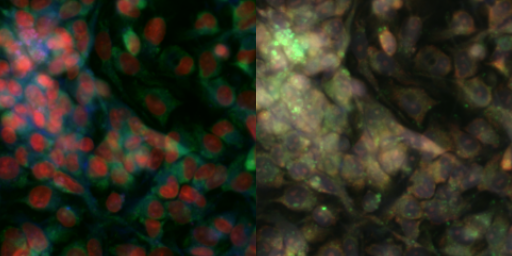

In [127]:
data.train_ds[0][0]

In [50]:
data.train_ds[0][0].data.shape

torch.Size([6, 128, 128])

In [ ]:
#data.train_ds[0][0].apply_tfms(crop(size=300, row_pct=(0,1), col_pct=(0,1)))

In [ ]:
### ORIGINAL 512px NO TFMS
data.train_ds[0][0]

### Adversarial full dataset

In [ ]:
data_a = (ImageList6D.from_df(df_train, path='train') # SET CORRECT DF!!!
        .split_from_df(col=-1) # split_by_rand_pct()
        .label_from_df(cols=-2, label_delim=' ') # label_delim=' ' for MultiCategoryList !
        .add_test(ImageList6D.from_df(df_train, path='train'))
        .transform(tfms, size=sz) # .transform(size=sz)
        .databunch(bs=bs))

In [ ]:
data_a

In [ ]:
data_a.c, len(data_a.classes), data_a.classes[-5:]

In [ ]:
data_a.batch_size

In [ ]:
data_a.train_ds[0]

In [ ]:
#data_a.classes

In [ ]:
data_a.train_ds[0][1], data_a.train_ds[0][1].data

In [ ]:
data_a.train_ds[0][1].data.sum()

In [ ]:
np.where(data_a.train_ds[0][1].data > 0.5)

In [ ]:
[data_a.classes[j] for j in np.where(data_a.train_ds[0][1].data > 0.5)[0]]

In [ ]:
data_a.train_ds[0][0]

In [ ]:
# DOES NOT WORK?
#data_a.train_ds[0][0].show()

# Model setup

## SE-XResNet

In [ ]:
# Check regularly for improvments: https://github.com/fastai/fastai_dev/blob/master/dev/60_vision_models_xresnet.ipynb

In [35]:
# from https://github.com/Cadene/pretrained-models.pytorch/blob/master/pretrainedmodels/models/senet.py#L85
class SE_Module(Module): # change nn.Module to Module

    def __init__(self, channels, reduction=16):
        #super(SE_Module, self).__init__() # not needed?
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x

In [36]:
# fastai resblock combined with SEModule
class SE_ResBlock(Module):
    def __init__(self, expansion, ni, nh, stride=1):
        nf,ni = nh*expansion,ni*expansion
        layers  = [conv_layer(ni, nh, 3, stride=stride),
                   conv_layer(nh, nf, 3, zero_bn=True, act=False)
        ] if expansion == 1 else [
                   conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 3, stride=stride),
                   conv_layer(nh, nf, 1, zero_bn=True, act=False)
        ]
        #self.convs = nn.Sequential(*layers) # without SEModule
        self.convs = nn.Sequential(*layers, SE_Module(nf))
        # TODO: check whether act=True works better
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return act_fn(self.convs(x) + self.idconv(self.pool(x)))

In [37]:
class SE_XResNetFeature(nn.Sequential):
    def __init__(self, expansion, layers, c_in=6):#, c_out=1108):
        stem = []
        sizes = [c_in,32,32,64]
        for i in range(3):
            stem.append(conv_layer(sizes[i], sizes[i+1], stride=2 if i==0 else 1))
            #nf = filt_sz(c_in*9)
            #stem.append(conv_layer(c_in, nf, stride=2 if i==1 else 1))
            #c_in = nf

        block_szs = [64//expansion,64,128,256,512]
        blocks = [self._make_layer(expansion, block_szs[i], block_szs[i+1], l, 1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        super().__init__(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            #AdaptiveConcatPool2d(), Flatten(),
            #nn.AdaptiveAvgPool2d(1), Flatten(),
            # remove head:
            #nn.Linear(block_szs[-1]*expansion, c_out)
        )
        init_cnn(self)

    def _make_layer(self, expansion, ni, nf, blocks, stride):
        return nn.Sequential(
            *[SE_ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(blocks)])

In [38]:
#se_xresnet152f = SE_XResNetFeature(4, [3,8,36,3], c_in=6) #, c_out=1108)
se_xresnet50f = SE_XResNetFeature(4, [3,4,6 ,3], c_in=6) #, c_out=1108)

In [39]:
se_xresnet50f(torch.randn(1,6,sz,sz)).shape

torch.Size([1, 2048, 4, 4])

In [40]:
#se_xresnet50f(data.train_ds[0][0].data.unsqueeze(0)).shape

In [41]:
#def set_rg(model=efficientnet_b3f, option=False):
#    for param in model.parameters():
#        param.requires_grad = option
#        
#set_rg()

### AdaCos-Head

In [42]:
def create_adacos_head(nf:int, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5,
                concat_pool:bool=True, bn_final:bool=False):
    #nc:int, 
    "Model head that takes `nf` features, runs through `lin_ftrs`, and about `nc` classes."
    
    lin_ftrs = [nf, 512, 512] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    # remove last 512 fc layer to reduce MODEL SIZE ??? ???
    
    ps = listify(ps)
    if len(ps) == 1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
    layers = [pool, Flatten()]
    for ni,no,p,actn in zip(lin_ftrs[:-1], lin_ftrs[1:], ps, actns):
        layers += bn_drop_lin(ni, no, True, p, actn)
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    #layers.append(AdaCos(lin_ftrs[-1], nc))
    return nn.Sequential(*layers)

In [43]:
adacos_head = create_adacos_head(nf=2048*2)

In [44]:
#adacos_head

In [45]:
adacos_head(torch.randn(2, 2048, 9, 9)).shape

torch.Size([2, 512])

In [46]:
# from https://github.com/4uiiurz1/pytorch-adacos/blob/master/metrics.py
class AdaCos(nn.Module):
    def __init__(self, num_features, num_classes, m=0.50):
        super(AdaCos, self).__init__()
        self.num_features = num_features
        self.n_classes = num_classes
        self.s = math.sqrt(2) * math.log(num_classes - 1)
        self.m = m
        self.W = nn.Parameter(torch.FloatTensor(num_classes, num_features))
        nn.init.xavier_uniform_(self.W)

    def forward(self, xb, yb):
        
        #print(yb.shape)
        #pdb.set_trace()
        
        # normalize features
        x = F.normalize(xb)
        # normalize weights
        W = F.normalize(self.W)
        # dot product
        logits = F.linear(x, W)
        
        # for training in non-AdaCos mode (= no yb date in the forward pass):
        if yb is None:
            print('yb = None')
            return logits
        
        # feature re-scale
        theta = torch.acos(torch.clamp(logits, -1.0 + 1e-7, 1.0 - 1e-7))
        one_hot = torch.zeros_like(logits)
        
        # ORIGINAL
        #one_hot.scatter_(1, yb.view(-1, 1).long(), 1)
        #with torch.no_grad():
        #    B_avg = torch.where(one_hot < 1, torch.exp(self.s * logits), torch.zeros_like(logits))
        #    B_avg = torch.sum(B_avg) / xb.size(0)
        #    #print(B_avg)
        #    theta_med = torch.median(theta[one_hot == 1])
        #    self.s = torch.log(B_avg) / torch.cos(torch.min(math.pi/4 * torch.ones_like(theta_med), theta_med))
        #    #print(self.s)
            
        # ADAPTED FOR CUTMIX TO GET MIXED SCALE PARAMETER
        with torch.no_grad():
            # FROM nb_new_data_augmentation_adacos2.py LINE 888
            # AND https://github.com/fastai/fastai/blob/master/fastai/callbacks/mixup.py#L40
            if yb.ndim == 2:# and target.shape[-1] >1:
                n_mod_patches = (yb.shape[-1] - 1) // 2
                #c_ = yb[:, 1:n_mod_patches + 1]
                c_ = yb[:, 0:n_mod_patches + 1]
                W_ = yb[:, n_mod_patches + 1:]
                self.s_scaled = []
                
                # this loop is only realdy needed when we have different probabilities inside a batch
                # which we do not have (right now)! So this could be cleaned up, but we leave until
                # we know we will not need the case with different probabilities in a batch.
                for k in range(n_mod_patches+1):
                    yb_new = c_[:, k].long()
                    #pdb.set_trace()
                    
                    one_hot.scatter_(1, yb_new.view(-1,1).long(), 1)
                    
                    B_avg = torch.where(one_hot < 1, torch.exp(self.s * logits), torch.zeros_like(logits))
                    B_avg = torch.sum(B_avg) / xb.size(0)
                    theta_med = torch.median(theta[one_hot == 1])
                    self.s = torch.log(B_avg) / torch.cos(torch.min(math.pi/4 * torch.ones_like(theta_med), theta_med))
                    
                    if k+1 == len(range(n_mod_patches+1)):
                        #self.s_scaled.append((1-W_[:, k-1]) * self.s)
                        self.s_scaled.append((1-W_[0, k-1]) * self.s)
                        # For more than two the sum of W_[:, :k] has to be used!!!
                    else:
                        #self.s_scaled.append(W_[:, k] * self.s)
                        self.s_scaled.append(W_[0, k] * self.s)
                    # Mixed B_avg & self.s and single are not really far off, but now we have it coded
                    # se we keep it (until it breaks something later).
                self.s = torch.add(*self.s_scaled)
                # Clean up, self.s_scaled is just a vector with the same entry multiple times
                # when it is not indexed above with W_[0,... !
            else:
                one_hot.scatter_(1, yb.view(-1,1).long(), 1)
                B_avg = torch.where(one_hot < 1, torch.exp(self.s * logits), torch.zeros_like(logits))
                B_avg = torch.sum(B_avg) / xb.size(0)
                theta_med = torch.median(theta[one_hot == 1])
                self.s = torch.log(B_avg) / torch.cos(torch.min(math.pi/4 * torch.ones_like(theta_med), theta_med))
        
        output = self.s * logits

        return output

In [47]:
class AdaCosNet(nn.Module):
    '''Simple AdaCosNet connecter to run xb through the feature extractor head
    and then feed xb and yb into the AdaCos layer.'''
    def __init__(self, body, head):
        super(AdaCosNet, self).__init__()
        self.body = body
        self.head = head
        self.adacos = AdaCos(512, 1108)
        
    def forward(self, xb, yb=None): # yb=None for training in non-AdaCos mode!
        features = self.body(xb)
        out = self.head(features)
        #print('xb.shape: ', xb.shape,', yb.shape: ', yb.shape)
        out = self.adacos(out, yb)
        #print('out: ',out.shape)
        #pdb.set_trace()
        return out

In [48]:
adacos_se_xresnet50c = AdaCosNet(se_xresnet50f, adacos_head)

In [49]:
adacos_se_xresnet50c(torch.randn(2,6,sz,sz)).shape

yb = None


torch.Size([2, 1108])

In [50]:
adacos_se_xresnet50c(torch.randn(2,6,sz,sz), torch.tensor([513, 1])).shape

torch.Size([2, 1108])

In [51]:
test_target = torch.tensor(
    [[2.4700e+02, 3.3900e+02, 7.8362e-01],
     [2.3300e+02, 7.7400e+02, 7.8362e-01],
     [7.7400e+02, 1.3400e+02, 7.8362e-01],
     [6.9800e+02, 8.4700e+02, 7.8362e-01]])

In [52]:
adacos_se_xresnet50c(torch.randn(4,6,sz,sz), test_target).shape

torch.Size([4, 1108])

In [53]:
# Based on https://forums.fast.ai/t/teacher-forcing/29415/4
# https://forums.fast.ai/t/on-batch-begin-callback/35201/3
@dataclass
class AppendBatchTargs(Callback):
    learn:Learner
    def __init__(self, learn):
        super().__init__()
    def on_batch_begin(self, last_input, last_target, **kwargs):
        return {'last_input':(last_input, last_target), 'last_target':last_target}

# Training

## SE-XResNet50c

In [128]:
learn = Learner(data, adacos_se_xresnet50c, metrics=[accuracy],
                callback_fns=[CSVLogger, AppendBatchTargs])#.to_fp16()

In [58]:
# https://github.com/pytorch/pytorch/issues/7455
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [59]:
#labsmooth_loss = LabelSmoothingLoss(1108, 0.1)

In [60]:
#input = torch.randn(3, 5, requires_grad=True)
#target = torch.empty(3, dtype=torch.long).random_(5)
#labsmooth_loss(input, target)

tensor(1.3397, grad_fn=<MeanBackward0>)

In [55]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [62]:
#learn.loss_func = labsmooth_loss
#learn.loss_func

In [87]:
# generate layer groups for discriminative layer training
# https://docs.fast.ai/basic_train.html#Discriminative-layer-training
#learn.split((adacos_efficientnet_b3.body._conv_stem,
#             #adacos_efficientnet_b3.body._blocks, # all blocks as a layer group
#             *[adacos_efficientnet_b3.body._blocks[i] for i in range(26)], # put in each block in
#             adacos_efficientnet_b3.body._conv_head,
#             adacos_efficientnet_b3.head,
#             adacos_efficientnet_b3.adacos
#            ));

In [88]:
# we have 30 layer groups!
#len(learn.lr_range(slice(1e-5,1e-3)))

In [59]:
learn.opt_func

functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99))

In [90]:
# https://docs.fast.ai/callbacks.fp16.html
#learn.to_fp16(loss_scale=512, clip=1e3);

In [91]:
# Make Adam FP16 proof:
# https://forums.fast.ai/t/mixed-precision-training/29601/21
# https://discuss.pytorch.org/t/adam-half-precision-nans/1765
# https://vxlabs.com/2019/02/04/improving-fastais-mixed-precision-support-with-nvidias-automatic-mixed-precision/
#learn.opt_func = partial(learn.opt_func, eps=1e-4)
#learn.opt_func
#
### ADD CLIP PARAMETER TOO???

functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99), eps=0.0001)

In [77]:
#learn.layer_groups

In [56]:
def check_rg(model=learn.model):
    layer_rg = [(n, p.requires_grad) for n,p in model.named_parameters()]
    for i in range(len(layer_rg)):
        print(f'{layer_rg[i][0]}\t{layer_rg[i][1]}'.expandtabs(40))

In [57]:
# unfreeze network
#learn.unfreeze()
#set_rg(learn.model.body, option=True)

In [58]:
check_rg() # check where trainable

body.0.0.weight                         True
body.0.1.weight                         True
body.0.1.bias                           True
body.1.0.weight                         True
body.1.1.weight                         True
body.1.1.bias                           True
body.2.0.weight                         True
body.2.1.weight                         True
body.2.1.bias                           True
body.4.0.convs.0.0.weight               True
body.4.0.convs.0.1.weight               True
body.4.0.convs.0.1.bias                 True
body.4.0.convs.1.0.weight               True
body.4.0.convs.1.1.weight               True
body.4.0.convs.1.1.bias                 True
body.4.0.convs.2.0.weight               True
body.4.0.convs.2.1.weight               True
body.4.0.convs.2.1.bias                 True
body.4.0.convs.3.fc1.weight             True
body.4.0.convs.3.fc1.bias               True
body.4.0.convs.3.fc2.weight             True
body.4.0.convs.3.fc2.bias               True
body.4.0.i

In [ ]:
#learn.summary()

### crop 128px

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-05
Min loss divided by 10: 2.51E-04


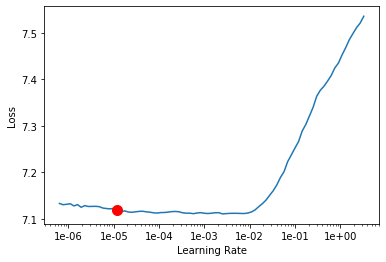

In [63]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [64]:
learn.fit_one_cycle(4, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,7.117241,7.109141,0.001422,10:28
1,7.061201,7.023956,0.001680,10:30
2,6.947589,6.913929,0.002068,10:29
3,6.882889,6.878943,0.002585,10:27


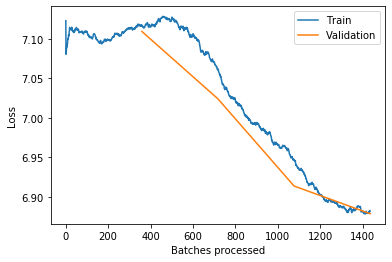

In [65]:
learn.recorder.plot_losses()

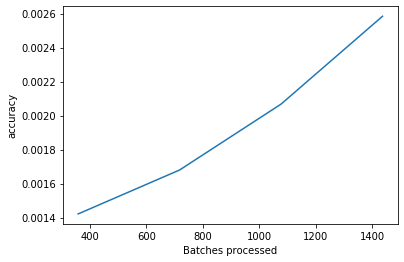

In [66]:
learn.recorder.plot_metrics()

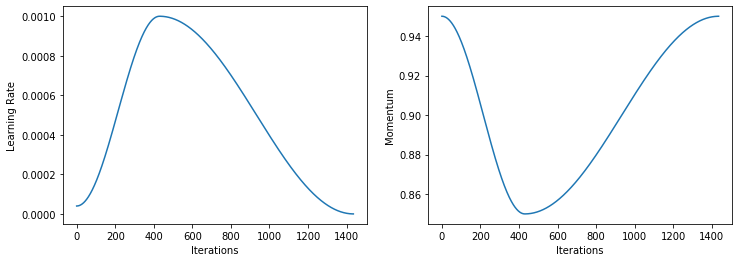

In [67]:
learn.recorder.plot_lr(show_moms=True)

In [68]:
learn.save('resnet50/adacos_se_xresnet50c_crop_e004_190808')

In [69]:
learn.load('resnet50/adacos_se_xresnet50c_crop_e004_190808');

Learner(data=ImageDataBunch;

Train: LabelList (57554 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: CategoryList
513,840,1020,254,144
Path: train;

Valid: LabelList (15476 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: CategoryList
352,361,503,505,70
Path: train;

Test: LabelList (39794 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: EmptyLabelList
,,,,
Path: train, model=AdaCosNet(
  (body): SE_XResNetFeature(
    (0): Sequential(
      (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=

In [70]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.881521,6.904902,0.003166,10:29
1,6.919456,6.925850,0.001680,10:30
2,6.888648,6.891063,0.002585,10:32
3,6.821239,6.843845,0.003360,10:30
4,6.761535,6.792528,0.005428,10:31
5,6.691651,6.766050,0.005622,10:34
6,6.631653,6.752459,0.006914,10:30
7,6.607954,6.755023,0.006074,10:30


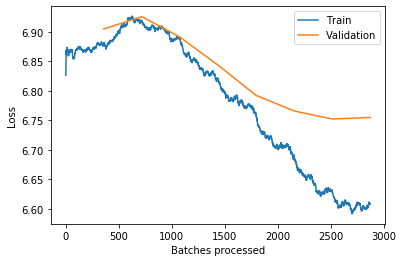

In [71]:
learn.recorder.plot_losses()

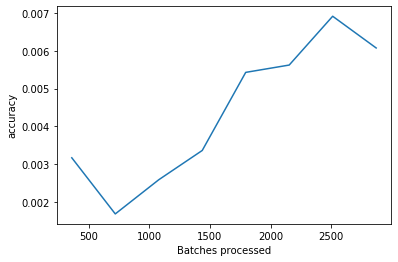

In [72]:
learn.recorder.plot_metrics()

In [73]:
learn.save('resnet50/adacos_se_xresnet50c_crop_e012_190808')

In [59]:
learn.load('resnet50/adacos_se_xresnet50c_crop_e012_190808');

In [60]:
#learn.lr_find()
#learn.recorder.plot(suggestion=True)

In [61]:
learn.fit_one_cycle(35, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,6.605061,6.754934,0.006655,10:33
1,6.584022,6.744287,0.006591,10:29
2,6.592481,6.747458,0.006526,10:33
3,6.583238,6.747379,0.006914,10:30
4,6.587788,6.741522,0.007172,10:30
5,6.567254,6.742331,0.006979,10:30
6,6.565007,6.726745,0.006914,10:32
7,6.562869,6.731340,0.007172,10:29
8,6.562420,6.728019,0.006849,10:30
9,6.539396,6.724786,0.007819,10:31


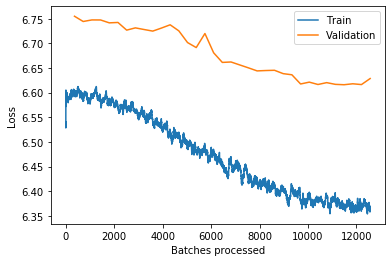

In [62]:
learn.recorder.plot_losses()

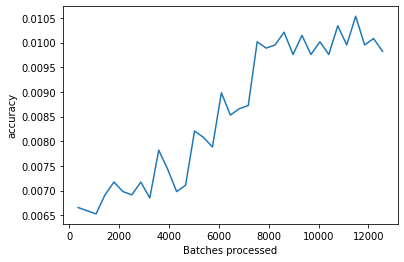

In [63]:
learn.recorder.plot_metrics()

In [64]:
learn.save('resnet50/adacos_se_xresnet50c_crop_e037_190808')

In [65]:
learn.load('resnet50/adacos_se_xresnet50c_crop_e037_190808');

### crop 256px

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-06
Min loss divided by 10: 8.32E-05


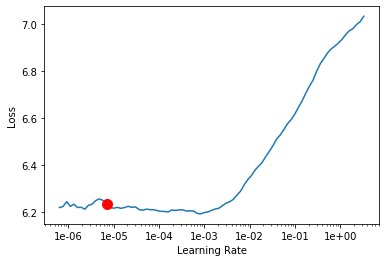

In [94]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [95]:
learn.fit_one_cycle(4, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.517439,6.776845,0.008142,13:00
1,6.481303,6.618801,0.011049,13:06
2,6.224692,6.351157,0.018222,13:05
3,6.084870,6.324934,0.019449,13:05


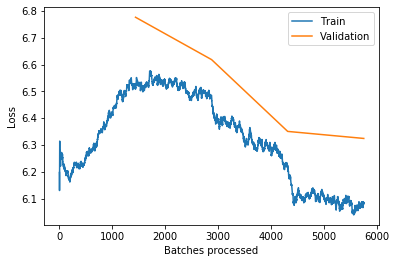

In [96]:
learn.recorder.plot_losses()

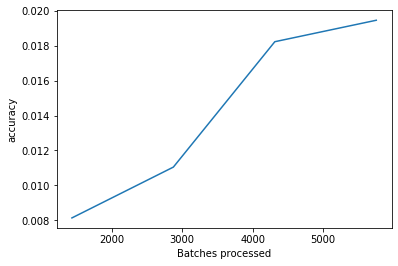

In [97]:
learn.recorder.plot_metrics()

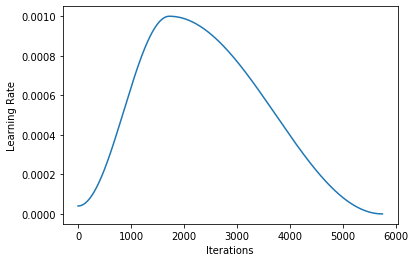

In [98]:
learn.recorder.plot_lr()

In [99]:
learn.save('resnet50/adacos_se_xresnet50c_crop_128e037_256e004_190809')

In [102]:
learn.load('resnet50/adacos_se_xresnet50c_crop_128e037_256e004_190809');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-04
Min loss divided by 10: 7.59E-08


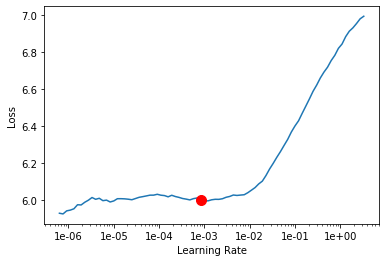

In [103]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [104]:
learn.fit_one_cycle(40, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.045908,6.339709,0.019837,13:06
1,6.009887,6.294395,0.020871,13:05
2,6.018590,6.259295,0.022874,13:04
3,6.001720,6.327971,0.021840,13:11
4,6.026535,6.235993,0.024231,13:06
5,6.040327,6.227506,0.023585,13:06
6,6.020312,6.403087,0.018028,13:07
7,6.054552,6.209047,0.023843,13:07
8,6.073259,6.237694,0.023068,13:04
9,6.020287,6.207142,0.022745,13:09


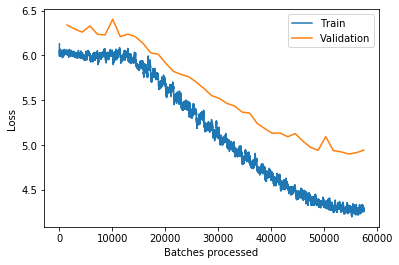

In [105]:
learn.recorder.plot_losses()

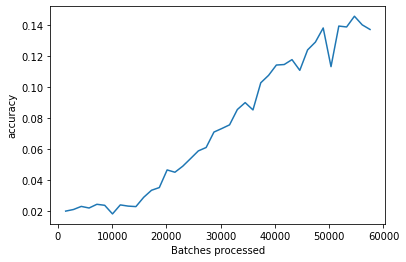

In [106]:
learn.recorder.plot_metrics()

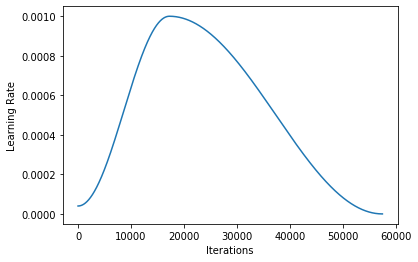

In [107]:
learn.recorder.plot_lr()

In [108]:
learn.save('resnet50/adacos_se_xresnet50c_crop_128e037_256e044_190809')

In [129]:
learn.load('resnet50/adacos_se_xresnet50c_crop_128e037_256e044_190809');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 6.31E-08


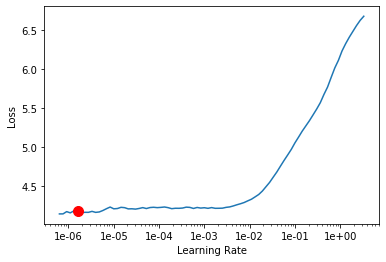

In [111]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [130]:
learn.fit_one_cycle(40, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.241697,4.927751,0.139377,12:59
1,4.187906,4.922331,0.136922,12:59
2,4.293849,4.955927,0.133045,13:02
3,4.310701,4.954968,0.131559,13:00
4,4.364697,4.929591,0.140152,13:00
5,4.417659,5.053949,0.119023,12:59
6,4.482027,4.993235,0.127358,13:05
7,4.484681,4.976532,0.129814,13:09
8,4.542000,5.068339,0.115469,13:02
9,4.484055,5.042931,0.120832,13:02


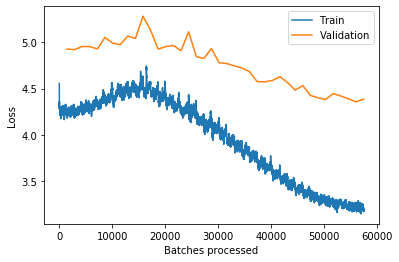

In [131]:
learn.recorder.plot_losses()

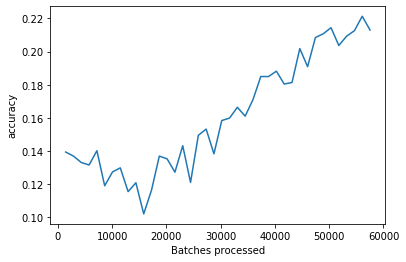

In [132]:
learn.recorder.plot_metrics()

In [133]:
#learn.recorder.plot_lr()

In [134]:
learn.save('resnet50/adacos_se_xresnet50c_crop_128e037_256e084_190809')

In [135]:
learn.load('resnet50/adacos_se_xresnet50c_crop_128e037_256e084_190809');

In [136]:
learn.fit_one_cycle(40, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,3.205866,4.404510,0.210261,13:02
1,3.226297,4.418028,0.210907,13:07
2,3.233239,4.395405,0.214655,13:06
3,3.176177,4.374644,0.216852,13:04
4,3.250414,4.521225,0.193978,13:07
5,3.241083,4.384122,0.214784,13:03
6,3.241242,4.394127,0.216723,13:06
7,3.238404,4.394095,0.212587,13:03
8,3.257320,4.384748,0.215753,13:07
9,3.201086,4.416564,0.209486,13:02


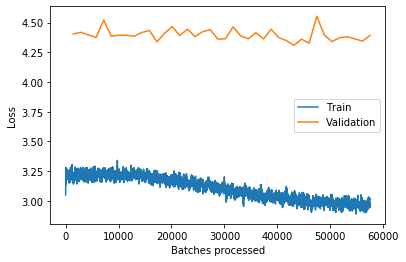

In [137]:
learn.recorder.plot_losses()

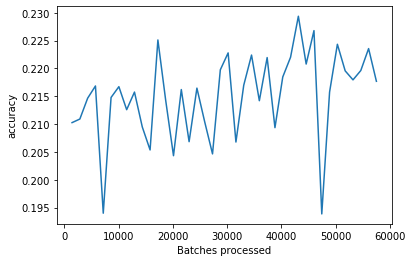

In [138]:
learn.recorder.plot_metrics()

In [139]:
#learn.recorder.plot_lr()

In [140]:
learn.save('resnet50/adacos_se_xresnet50c_crop_128e037_256e124_190809')

In [141]:
learn.load('resnet50/adacos_se_xresnet50c_crop_128e037_256e124_190809');

### CutMix 1-Cycle #1

In [ ]:
#learn.load('resnet50/adacos_se_xresnet50c_crop_128e037_256e084_190809');

In [142]:
learn.cutmix();

In [ ]:
# w CutMix
#learn.lr_find()
#learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(40, max_lr=1e-3)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
#learn.recorder.plot_lr()

In [ ]:
learn.save('resnet50/adacos_se_xresnet50c_crop_128e037_256e084CM040_190809')

In [ ]:
learn.load('resnet50/adacos_se_xresnet50c_crop_128e037_256e084CM040_190809');

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

### Custom Blend CutMix

In [ ]:
kwargs = {
    'size': .05, 
    'alpha': .2,
    'blend_type': 'zero', 
}

In [ ]:
learn.blend(**kwargs);

In [ ]:
learn.fit_one_cycle(4, 1e-3)

In [ ]:
%debug

In [ ]:
# Define transform function
tfm_fn = partial(blend, blend_type='cut', same_size=False)

#Define schedule parameters
sch_param=['size', 'fixed_proba']
sch_val = [(.05, 2), .2 ]  # You can also enter a list of tuples
sch_iter = [(0., .3), (0., .7)]  # And a tuple with start and end iteration percentage
sch_func = [annealing_cos, partial(cosine_annealing, pct_start=.3)] # options: None = annealing_linear, annealing_cos, cosine_annealing
plot = True
test = True  # if True this will stop training in the first mini-batch
sch_tfm_cb = partial(TfmScheduler, tfm_fn=tfm_fn, sch_param=sch_param, sch_val=sch_val, 
                      sch_iter=sch_iter, sch_func=sch_func, plot=plot, test=test)
learn.callback_fns.append(sch_tfm_cb)

# Submission

## Classifcation

In [ ]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106CMe110_20190729');

In [ ]:
# get prediction of test dataset
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
# check length
len(preds)

In [ ]:
# get the categories
preds_cat = preds.argmax(dim=-1)

In [ ]:
# get the names
preds_names = learn.data.test_ds.x.items

In [ ]:
# without site
#preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3][:3] for x in preds_names]

# with site
preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3] for x in preds_names]

In [ ]:
df_preds = pd.DataFrame({'id_code_site': preds_names, 'sirna': preds_cat})

In [ ]:
# get id_code without site
df_preds['id_code'] = df_preds['id_code_site'].apply(lambda x: x[:-3])

In [ ]:
# get row indices with the same/not the same the prediction for both sites
idx = [] # indices with the same prediction
idx_notsame = [] # indices with not the same prediction
for i, r in enumerate(df_preds.sort_values('id_code').iterrows()):
    if i % 2:
        # distance from row 2 is 
        if pred == r[1]['sirna']:
            idx.append(r[0])
        else:
            #idx.append(r[0]) # always append idx until we come up with something better
            idx.append(idx_row_before)
            idx_notsame.append(idx_row_before) # get the first rows of the pairs that are not the same
    else:
        # save dist from row 1 for comparison in next iteration
        pred = r[1]['sirna']
        idx_row_before = r[0]

In [ ]:
len(idx), len(idx_notsame)

In [ ]:
idx[:5]

In [ ]:
df_preds.sort_values('id_code').head(10)

In [ ]:
#df_preds.loc[idx,['id_code','sirna']]

In [ ]:
# 'effnet/adacos_efficientnet_b3_e080CM112_190805'
model = 'metriclearn_efficientnet_b3_e080CM112_190805'

In [ ]:
df_preds.loc[idx,['id_code','sirna']].to_csv('sub/'+model+'.csv.gz', index=False, compression='gzip')

In [ ]:
!kaggle competitions submit -c recursion-cellular-image-classification -f sub/{model}.csv.gz -m "{model}"


## Cosinus similarity

### Full single features

In [ ]:
# https://github.com/ducha-aiki/whale-identification-2018/blob/master/reproduce_problems.ipynb
# And for test-time augmentation I used following random solution: switch train and val transforms

In [ ]:
# extended tfms
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_rotate=90.0, max_zoom=1.1, 
                      max_lighting=0.2, max_warp=0.2, 
                      p_affine=0.75, p_lighting=0.75, 
                      xtra_tfms=[color_augmentation()])

# crop_pad: https://forums.fast.ai/t/misc-issues/35386/10

In [ ]:
# extended tfms w/o color_augmentation !!!
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_rotate=90.0, max_zoom=1.1, 
                      max_lighting=0.2, max_warp=0.2, 
                      p_affine=0.75, p_lighting=0.75)

In [ ]:
# sz, bs = 300, 8*2
sz, bs = 512, 8*3

In [ ]:
# VALID SPLIT (incl. tfms)
data = (ImageList6D.from_df(df_train, path='train')
        .split_from_df(col=-1) # split_by_rand_pct()
        .label_from_df(cols=-3)
        .add_test(ImageList6D.from_df(df_test, path='test'))
        .transform(tfms)#, size=sz) # remove size so we get the crop size!
        .databunch(bs=bs))

In [ ]:
# Batch-wise normalization should be enough because the deviation is max. 6%
# see "rcic_v10_inspect_image_data.ipynb" for analysis.
#data.normalize() # https://docs.fast.ai/vision.data.html#ImageDataBunch.batch_stats

data.normalize([tensor([0.0456, 0.0702, 0.0447, 0.0468, 0.0407, 0.0399]),
                tensor([0.0644, 0.0733, 0.0536, 0.0633, 0.0555, 0.0392])]);

# efficientnet stats https://github.com/lukemelas/EfficientNet-PyTorch#example-classification
#data.normalize(([0.485, 0.456, 0.406, 0.485, 0.456, 0.406],
#               [0.229, 0.224, 0.225, 0.229, 0.224, 0.225]))

# mean of mean, and mean of std from rcic_v10_inspect_image_data.ipynb
#data.normalize()

In [ ]:
#data.train_dl.dl.batch_sampler.sampler = torch.utils.data.SequentialSampler(data.train_ds)
#data.train_dl.dl.batch_sampler.drop_last = False
#
#data.valid_dl.dl.batch_sampler.sampler = torch.utils.data.SequentialSampler(data.valid_ds)
#data.valid_dl.dl.batch_sampler.drop_last = False
#
## DOES WORK TOO FOR TEST DL ??? ??? (Or do we need to set the test dataset to the valid dataset?)
#data.test_dl.dl.batch_sampler.sampler = torch.utils.data.SequentialSampler(data.test_ds)
#data.test_dl.dl.batch_sampler.drop_last = False

In [ ]:
learn = Learner(data, adacos_efficientnet_b3)

In [ ]:
learn.load('effnet/adacos_efficientnet_b3_e080CM185-230_190807_best')

In [ ]:
def get_feats(model, dataloader, cycles=1):
    feats = []
    targs = []
    model.eval()
    with torch.no_grad():
        for i in range(cycles): # for TTA
            for xb, yb in dataloader:
                body_out = model.body(xb)
                head_out = model.head(body_out)
                feats.append(head_out.cpu())
                targs.append(yb.cpu())
    return feats, targs

#### Train

In [ ]:
feats, targs = get_feats(learn.model, learn.data.train_dl)#, cycles=3)

In [ ]:
len(feats), len(targs)

In [ ]:
# total images: 89*320
learn.data.batch_size * len(learn.data.train_dl)

In [ ]:
#len(learn.data.train_dl), len(learn.data.valid_dl), len(learn.data.test_dl)

In [ ]:
feats = torch.cat(feats, dim=0)
targs = torch.cat(targs, dim=0)

In [ ]:
feats.shape, targs.shape

In [ ]:
np.save('pred/feats_train.npy', feats)
np.save('pred/targs_train.npy', targs)

#### Valid

In [ ]:
feats, targs = get_feats(learn.model, learn.data.valid_dl)

In [ ]:
len(feats), len(targs)

In [ ]:
feats = torch.cat(feats, dim=0)
targs = torch.cat(targs, dim=0)

In [ ]:
feats.shape, feats.shape, targs.shape

In [ ]:
np.save('pred/feats_valid.npy', feats)
np.save('pred/targs_valid.npy', targs)

#### Test

In [ ]:
feats, targs = get_feats(learn.model, learn.data.test_dl)

In [ ]:
del targs

In [ ]:
len(feats)

In [ ]:
feats = torch.cat(feats, dim=0)

In [ ]:
feats.shape

In [ ]:
np.save('pred/feats_test.npy', feats)

### Multi-crop features

In [ ]:
# https://github.com/ducha-aiki/whale-identification-2018/blob/master/reproduce_problems.ipynb
# And for test-time augmentation I used following random solution: switch train and val transforms

In [ ]:
df_train['test'] = 0
df_train['path'] = 'train/'+df_train['path']

In [ ]:
df_train.head()

In [ ]:
# add dummy columns for test dataset
df_test['path'] = 'test/'+df_test['path']
df_test['test'] = 1
df_test['sirna'] = 1

In [ ]:
df_test.head()

In [ ]:
df_train_test = pd.concat((df_train, df_test), axis=0, sort=False)

In [ ]:
df_train_test.tail()

In [ ]:
# reload for train and valid ds
df_train = pd.read_csv('full_train_dataset_valid-split-ex_v2_20190727.csv', index_col=0)
df_test = pd.read_csv('full_test_dataset_v2_20190727.csv', index_col=0)

In [ ]:
# test tfms switching for test ds
#tfms_switched = (tfms[1], tfms[0])
#
#data = (ImageList6D.from_df(df_train_test, path='.')
#                .split_from_df(col=-1)
#                .label_from_df(cols=-4)
#                .transform(tfms_switched)#, size=sz) # remove size so we get the crop size!
#                .databunch(bs=bs))

In [ ]:
#data.train_ds[0][0]

In [ ]:
#data.valid_ds[0][0]

In [ ]:
def get_dataset(row_pct, col_pct, is_test=False):
    # extended tfms
    tfms = get_transforms(do_flip=True, flip_vert=True, 
                          max_rotate=90.0, max_zoom=1.1, 
                          max_lighting=0.2, max_warp=0.2, 
                          p_affine=0.75, p_lighting=0.75, 
                          xtra_tfms=[color_augmentation()])
    
    # change "crop_pad" from get_transforms to "crop"
    tfms[0][0] = crop(size=sz, row_pct=row_pct, col_pct=col_pct)
    tfms[1][0] = crop(size=sz, row_pct=row_pct, col_pct=col_pct)
    
    # VALID SPLIT (incl. tfms)
    if is_test:
        #switch train with valid (= test) tfms!
        tfms_switched = (tfms[1], tfms[0])
        
        data = (ImageList6D.from_df(df_train_test, path='.')
                .split_from_df(col=-1)
                .label_from_df(cols=-4)
                .transform(tfms_switched)#, size=sz) # remove size so we get the crop size!
                .databunch(bs=bs))
    else:
        data = (ImageList6D.from_df(df_train, path='train')
                .split_from_df(col=-1) # split_by_rand_pct()
                .label_from_df(cols=-3)
                #.add_test(ImageList6D.from_df(df_test, path='test'))
                .transform(tfms)#, size=sz) # remove size so we get the crop size!
                .databunch(bs=bs))
    
    data.normalize([tensor([0.0456, 0.0702, 0.0447, 0.0468, 0.0407, 0.0399]),
                    tensor([0.0644, 0.0733, 0.0536, 0.0633, 0.0555, 0.0392])]);
    
    return data

In [ ]:
def get_feats(model, dataloader, cycles=1):
    feats = []
    targs = []
    model.eval()
    with torch.no_grad():
        for i in range(cycles): # for TTA
            for xb, yb in dataloader:
                body_out = model.body(xb)
                head_out = model.head(body_out)
                feats.append(head_out.cpu())
                targs.append(yb.cpu())
                
    feats = torch.cat(feats, dim=0)
    targs = torch.cat(targs, dim=0)
    
    return feats, targs

In [ ]:
def save_feats(feats, targs, crop, ds='train'):
    np.save(f'pred/feats_{ds}_crop{crop}.npy', feats)
    np.save(f'pred/targs_{ds}_crop{crop}.npy', targs)

In [ ]:
#https://docs.fast.ai/vision.transform.html#_crop
crop_pos = [[0.,0.], [0.,1.],[0.5,0.5],[1.,0.], [1.,1.]]

In [ ]:
# get random crop pos
i = 2
crop_pos = [[uniform(0,1), uniform(0,1)] for i in range(2)]

In [ ]:
crop_pos

In [ ]:
# get the last three crop positions:
crop_pos = [[0.5,0.5],[1.,0.], [1.,1.]]

In [ ]:
def get_crop_feats(model=learn.model, cycles=1, crop_pos=crop_pos):
    
    for i, (row_pct, col_pct) in enumerate(crop_pos):
        
        print('== crop#:', i,' of', len(crop_pos), '==')
        print('row_pct:', row_pct,', col_pct:', col_pct)
    
        data = get_dataset(row_pct, col_pct)
        
        # train
        print('= Start train dataset =')
        feats, targs = get_feats(model, data.train_dl)
        save_feats(feats, targs, i, ds='train')
        print('feats:', feats.shape,' targs:', targs.shape)
        print('- Finish train dataset -')
        
        # valid
        print('= Start valid dataset =')
        feats, targs = get_feats(model, data.valid_dl)
        save_feats(feats, targs, i, ds='valid')
        print('feats:', feats.shape,' targs:', targs.shape)
        print('- Finish valid dataset -')
        
        # get test ds as valid ds for TTA
        data = get_dataset(row_pct, col_pct, is_test=True)
        
        # test
        print('= Start test dataset =')
        feats, targs = get_feats(model, data.valid_dl)
        save_feats(feats, targs, i, ds='test')
        print('feats:', feats.shape,' targs:', targs.shape)
        print('- Finish test dataset -')

In [ ]:
learn = Learner(data, adacos_efficientnet_b3)

In [ ]:
learn.load('effnet/adacos_efficientnet_b3_e080CM112_190805');

In [ ]:
get_crop_feats()

In [ ]:
#data = (ImageList6D.from_df(df_train_test, path='.')
#        .split_from_df(col=-1)
#        .label_from_df(cols=-4)
#        .transform(tfms_switched)#, size=sz) # remove size so we get the crop size!
#        .databunch(bs=bs))

### Submission

In [ ]:
# get the names
preds_names = learn.data.test_ds.x.items

In [ ]:
# without site
#preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3][:3] for x in preds_names]

# with site
preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3] for x in preds_names]

In [ ]:
preds_test = np.load('pred/preds_test.npy')
dist_test = np.load('pred/dist_test.npy')

In [ ]:
len(preds_names), len(preds_test), len(dist_test)

In [ ]:
#preds_test

In [ ]:
#dist_test

In [ ]:
df_preds = pd.DataFrame({'id_code_site': preds_names, 'sirna': preds_test, 'cossim': dist_test})

In [ ]:
# get id_code without site
df_preds['id_code'] = df_preds['id_code_site'].apply(lambda x: x[:-3])

In [ ]:
# get row indices with highest cosine similiarity
idx = []
for i, r in enumerate(df_preds.sort_values('id_code').iterrows()):
    #print(r)
    #print('i: ',i)
    #print('idx: ',r[0])
    #print(r[1]['cossim'])
    if i % 2:
        # distance from row 2 is 
        if dist < r[1]['cossim']:
            idx.append(r[0])
        else:
            idx.append(idx_row_before)
    else:
        # save dist from row 1 for comparison in next iteration
        dist = r[1]['cossim']
        idx_row_before = r[0]

In [ ]:
idx[:5]

In [ ]:
df_preds.sort_values('id_code').head(10)

In [ ]:
#df_preds.loc[idx,['id_code','sirna']]

In [ ]:
# 'effnet/adacos_efficientnet_b3_e080CM185-230_190807_best'
model = 'metriclearn_efficientnet_b3_e080CM185-230_190807_best_512px-no-col-aug'

In [ ]:
df_preds.loc[idx,['id_code','sirna']].to_csv('sub/'+model+'.csv.gz', index=False, compression='gzip')

In [ ]:
!kaggle competitions submit -c recursion-cellular-image-classification -f sub/{model}.csv.gz -m "{model}"


# Error analysis

In [ ]:
preds_correct = np.load('preds_valid_correct.npy')

In [ ]:
df_erros = pd.DataFrame({'id_code': preds_names, 'correct': preds_test})

In [ ]:
df_erros[df_errors['correct'] == False]

In [ ]:
# ERROR ANALYSIS !!!